# Primary Component Analysis (PCA)

Using Scikit Learn, apply PCA to reduce the dimension of MNIST (28x28) 

## PCA Pre-requisite

The dataset is centered around the origin. To do it manually by yourself with numpy (Scikit Learn PCA looks after centering the data, hence not required).

```
X_centered = X - X.mean(axis=0)
```

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import scipy as sp
import os

# to make this notebook's output stable across runs
np.random.seed(42)
np.set_printoptions(
    suppress=True #, formatter={'float_kind':'{:0.5f}'.format}
)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## MNIST

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)

In [3]:
mnist.target = mnist.target.astype(np.uint8)

# Split data into training and test
X, y = mnist["data"], mnist["target"]
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

del mnist

In [4]:
COVERAGE = 0.95

In [5]:
def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

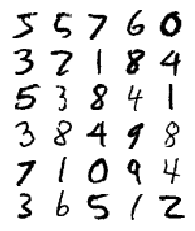

In [6]:
plot_digits(X_train[::2000])

# Mathematics

## Diagonalization
It is able to find the onthogonal bases, in the space of which the co-variances of the data becomes 0.

<img align="left" src="./images/pca/basis.diagonalization.png" width="1000">

## Primary Components

In that space, the variance along each basis is the contribution to the information that the data posseses. The basis along which the data has the maximum variance is the 1st primary component of the data. The basis that has 2nd maximum variance is the 2nd primary compoent, and so on. 

<img align="left" src="./images/pca/basis.variance_is_contribution.png" width="1000"> 

## Eigenvectors

Those onthogonal bases are the eigenvectors and the eigenvalues are the variances. 

<img align="left" src="./images/pca/basis.variance_to_primary_component.png" width="1000"> 


## Eigenvalues
Hence Primary Comonents can be identified from the eigenvalues. Contribution at each basis to the total information is <span style="color:red"><b>its variance</b></span>, which is represented by eigenvalues.

In [7]:
from sklearn.preprocessing import StandardScaler
# Feature scaling is optional
#X_centered = StandardScaler().fit_transform(X_train - X_train.mean(axis=0))
X_centered = X_train - X_train.mean(axis=0)

covariance_matrix = X_centered.T.dot(X_centered) 
eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)

### Plot eigenvalue cumulative

In [56]:
def plot_coverage(cumulatives, xlabel, ylabel):
    dimensions = range(0, len(cumulatives))

    # --------------------------------------------------------------------------------
    # Axes
    # [Axis limits]
    # With plt.axes() you are creating a new axes again. 
    # Use ax.set_xlim(a,b) and ax.set_ylim(a,b)
    # --------------------------------------------------------------------------------
    #plt.axis((0,max(dimensions),0,1.01))
    # --------------------------------------------------------------------------------
    ax = plt.gca()
    ax.set_xlim(0, max(dimensions))
    ax.set_ylim(0, 1.01)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    # --------------------------------------------------------------------------------
    # Grid
    # --------------------------------------------------------------------------------
    import math
    import matplotlib.ticker as ticker

    plt.grid(
        color='b',
        linestyle='--',
        linewidth=0.5,
        which='both'     # Both major and minor grids
    )

    # --------------------------------------------------------------------------------
    # Minor grid to highlight the range for the COVERAGE
    # --------------------------------------------------------------------------------
    k = np.argmax(cumulatives >= COVERAGE)
    print("k-th primary compoent for {0} coverage is {1}".format(str(COVERAGE), k))
    
    minors = range(0, math.ceil(k/100)*100, 10)[1:-1]
    ax.xaxis.set_minor_locator(ticker.FixedLocator(minors))
    ax.grid(
        which='minor', # Set the minor grid attributes
        alpha=0.5,     # Transparency
        lw=1, 
        color='r'
    )

    # --------------------------------------------------------------------------------
    # Cut-off COVERAGE line 
    # --------------------------------------------------------------------------------
    plt.plot([0.0, max(dimensions)], [COVERAGE, COVERAGE], "r:", lw=2, label=str(COVERAGE))
    
    # --------------------------------------------------------------------------------
    # Information coverage along Primary Components 
    # --------------------------------------------------------------------------------
    plt.plot(dimensions, cumulatives)

    plt.legend(
        loc='upper right',          # Legend location
        bbox_to_anchor=(0.98, 0.9), # Adjust the legend location
        prop={'size': 15}           # Font size
    )
    plt.show

k-th primary compoent for 0.95 coverage is 153


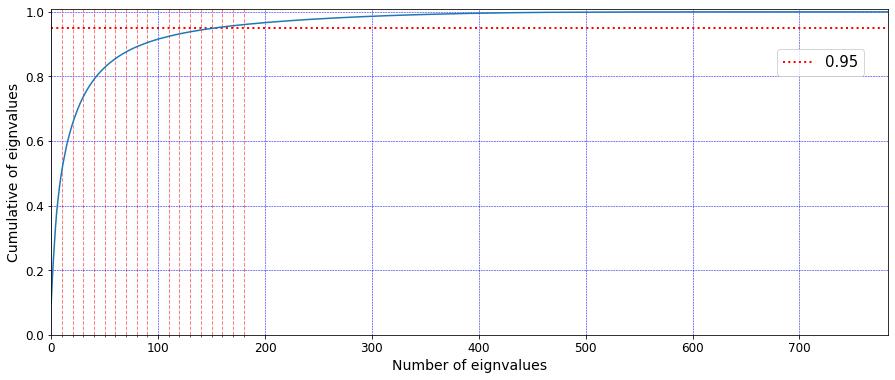

In [57]:
eigenvalues_cumulatives = (eigenvalues / eigenvalues.sum()).cumsum()

plt.figure(figsize=(15, 6))
plot_coverage(
    eigenvalues_cumulatives, 
    "Number of eignvalues", 
    "Cumulative of eignvalues"
)

## Map (Rorate & Extend)
<img align="left" src="./images/pca/basis.rotate_to_map.png" width="400"> 

## Transpose
<img align="left" src="./images/pca/VT.Semantic.png" width="1000"> 

<hr/>

# PCA

The idea of PCA (Primary Component Analysis) is to identify the top <b>k</b> primary components and ignore the rest of the components, by which the dimentionality can be reduced from n to k.

<img align="left" src="./images/pca/pca.idea.png" width="400">
<br/>

## Choosing k

Find <b>k</b> which preseves 99% (or 95%) of the variance of the data. <br/>

<cite><b> Andrew Ng</b></cite>
<pre>
<img align="left" src="./images/pca/andrew_ng_choosing_k.png" width="750">
</pre>

In [10]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

k-th primary compoent for 0.95 coverage is 153
Top 5 primary component contributions: [0.09705 0.16801 0.2297  0.28359 0.33228]
Coverage by the top 5 primary components: [0.09705 0.16801 0.2297  0.28359 0.33228]


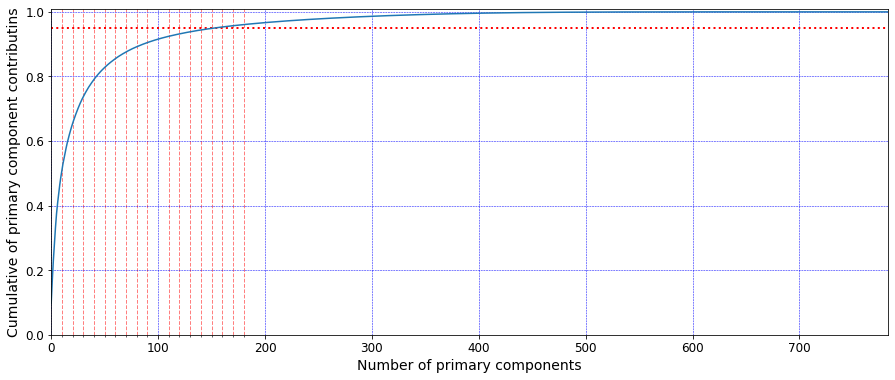

In [28]:
contribution_cumulatives = pca.explained_variance_ratio_.cumsum()

plt.figure(figsize=(15, 6))
plot_coverage(
    contribution_cumulatives, 
    "Number of primary components", 
    "Cumulative of primary component contributins"
)

print("Top 5 primary component contributions: {}".
      format(np.round(contribution_cumulatives[:5], decimals=5))
)
print("Coverage by the top 5 primary components: {}".
      format(np.round(contribution_cumulatives[:5], decimals=5))
)

In [12]:
pca_154 = PCA(n_components=154, svd_solver="randomized", random_state=4)
X_train_reduced = pca_154.fit_transform(X_train)
X_train_recovered = pca_154.inverse_transform(X_train_reduced)

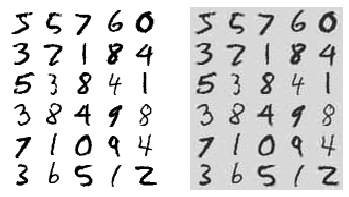

In [13]:
plt.subplot(121)
plot_digits(X_train[::2000])

plt.subplot(122)
plot_digits(X_train_recovered[::2000])
#plt.tight_layout()

With those (u, v), any matrix M, including a Covariance Matrix, can be decomposed as below.
<br/>
<img align="left" src="./images/pca/SVD.png" width="1000">

## Relation between SVD and PCA

The eignvectors <b>E</b> of PCA is the same with the singular vector <b>V</b> of SVD. <br/>
<img align="left" src="./images/pca/PCA_SVD_Relation.png" width="500">
<img align="left" src="./images/pca/SVD2PCA.png" width="1000">
<img align="left" src="./images/pca/SVD_PCA.png" width="1000">

### Plot singular value cumulative

In [14]:
X_centered = X_train - X_train.mean(axis=0)
# --------------------------------------------------------------------------------
# Use scipy to avoid numpy MemoryError: Unable to allocate array with shape
# https://stackoverflow.com/questions/19743525/
# https://github.com/numpy/numpy/issues/4268
# http://fa.bianp.net/blog/2012/singular-value-decomposition-in-scipy/
#
# Use full_matrices=False
# --------------------------------------------------------------------------------
#U, s, Vt = np.linalg.svd(X_centered)
# --------------------------------------------------------------------------------
U, s, Vt= sp.linalg.svd(X_centered, full_matrices=False)
# --------------------------------------------------------------------------------

In [15]:
n_samples, n_features = X_centered.shape

sigma_cumulatives = ((s ** 2) / (n_samples - 1)).cumsum()
sigma_cumulatives = sigma_cumulatives / sigma_cumulatives[-1]
k = np.argmax(np.array(sigma_cumulatives) >= COVERAGE)    

print("k-th component to cover {0} is {1}".format(sigma_cumulatives[k], k))

k-th component to cover 0.9501960192613037 is 153


k-th primary compoent for 0.95 coverage is 153


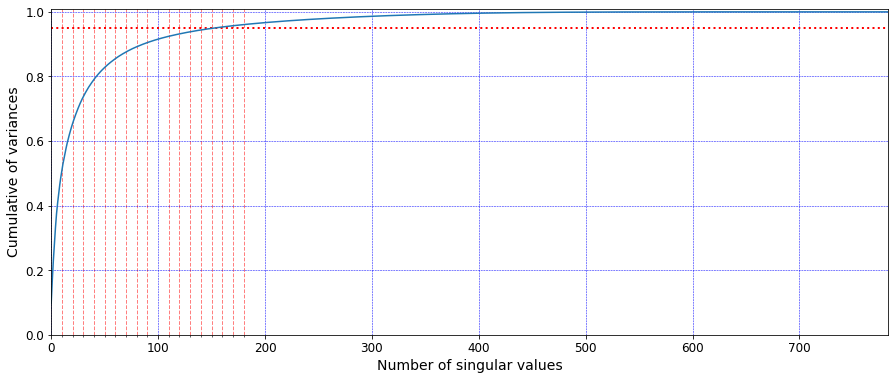

In [30]:
plt.figure(figsize=(15, 6))
plot_coverage(
    sigma_cumulatives, 
    "Number of singular values",
    "Cumulative of variances"
)

# Handling large data


## Incremental PCA
A large data can be split into mini-batches and Scikit learn IncrementalPCA can take one mini-batch at a time.

In [17]:
from sklearn.decomposition import IncrementalPCA

n_batches = 100
ipca = IncrementalPCA()
for X_batch in np.array_split(X_train, n_batches):
    ipca.partial_fit(X_batch)

X_reduced = ipca.transform(X_train)

/home/masa/anaconda3/envs/Jupyter-Notebook/lib/python3.7/site-packages/sklearn/decomposition/incremental_pca.py:294: RuntimeWarning: Mean of empty slice.
  explained_variance[self.n_components_:].mean()
/home/masa/anaconda3/envs/Jupyter-Notebook/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


k-th primary compoent for 0.95 coverage is 153


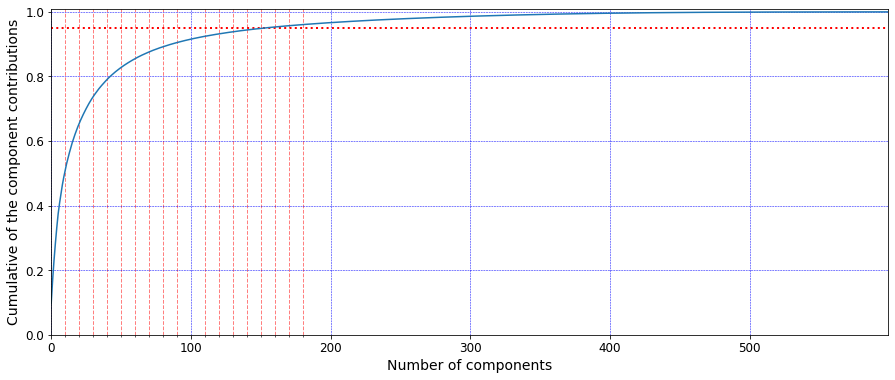

In [31]:
ipca_contribution_cumulatives = ipca.explained_variance_ratio_.cumsum()

plt.figure(figsize=(15, 6))
plot_coverage(
    ipca_contribution_cumulatives, 
    "Number of components", 
    "Cumulative of the component contributions"
)

In [19]:
ipca_154 = IncrementalPCA(n_components=154)
X_train_recuced_ipca = ipca_154.fit_transform(X_train)
X_train_recovered_ipca = ipca_154.inverse_transform(X_train_recuced_ipca)

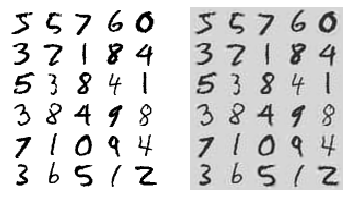

In [20]:
plt.subplot(121)
plot_digits(X_train[::2000])

plt.subplot(122)
plot_digits(X_train_recovered_ipca[::2000])

## Numpy memmap
NumPy’s memmap treat a large array stored in a file on disk as if it were entirely in memory. It loads only the data it needs in memory, when it needs it. Since the IncrementalPCA class uses only a small part of the array at any given time, the memory usage remains under control.

In [21]:
np.save("X_train.npy", X_train)
X_mm = np.load('X_train.npy', mmap_mode='r')
X_mm[9179][599]

200.0

In [23]:
from sklearn.decomposition import IncrementalPCA

m, n = X_train.shape
n_batches = 100
batch_size = m // n_batches

ipca_mm = IncrementalPCA(batch_size=batch_size)
ipca_mm.fit(X_mm)

/home/masa/anaconda3/envs/Jupyter-Notebook/lib/python3.7/site-packages/sklearn/decomposition/incremental_pca.py:294: RuntimeWarning: Mean of empty slice.
  explained_variance[self.n_components_:].mean()
/home/masa/anaconda3/envs/Jupyter-Notebook/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


IncrementalPCA(batch_size=600, copy=True, n_components=None, whiten=False)

k-th primary compoent for 0.95 coverage is 153


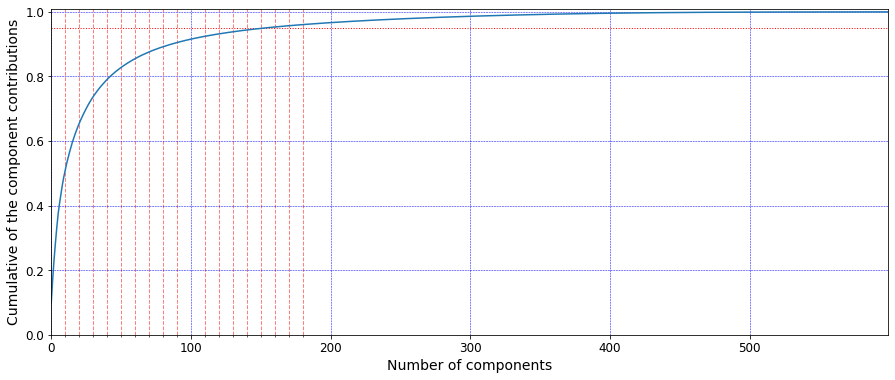

In [24]:
ipca_mm_contribution_cumulatives = ipca_mm.explained_variance_ratio_.cumsum()

plt.figure(figsize=(15, 6))
plot_coverage(
    ipca_mm_contribution_cumulatives, 
    "Number of components", 
    "Cumulative of the component contributions"
)